# Notebook 03 - Feature Engineering & Modeling

our goal is Use cleaned legal text to build a machine-learning model.
So for that We will:
Convert text to a numbers (feature engineering)
then Train a model
Evaluate performance using metrics like f1 score.....
Save results for GitHub & LinkedIn

In [4]:
#load cleaned dataset from notebook 02.
import pandas as pd

df_train = pd.read_csv("/kaggle/input/preprocessed-dataset/df_train_cleaned.csv")

df_train.head(2)

,case_id,case_no,title,judgment_date,facts,applicants,defendants,allegedly_violated_articles,violated_articles,court_assessment_references,silver_rationales,gold_rationales,text,outcome,text_length,clean_text,clean_text_length
0,001-59587,25702/94,CASE OF K. AND T. v. FINLAND,2001-07-12,['11. At the beginning of the events relevant...,"['K.', 'T.']",['FINLAND'],"['13', '8']",['8'],"{'8': ['12', '140', '155', '156', '157', '158'...","[1, 13, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30...",[],['11. At the beginning of the events relevant...,0,6886,11 beginning event relevant application k daug...,3817
1,001-59591,42527/98,CASE OF PRINCE HANS-ADAM II OF LIECHTENSTEIN v...,2001-07-12,['9. The applicant is the monarch of Liechten...,['PRINCE HANS-ADAM II OF LIECHTENSTEIN'],['GERMANY'],"['14', 'P1-1', '6']",[],"{'6': ['12', '15', '24', '25', '26', '27', '28...","[3, 6]",[],['9. The applicant is the monarch of Liechten...,0,2747,9 applicant monarch liechtenstein born 1945 li...,1529


ML models cannot read text, therefore We already cleaned text and  reuse it.



In [5]:
#Our target variable is Outcome. So, Understand the target variable (outcome)
df_train['outcome'].value_counts()

outcome
0    8347
1     653
Name: count, dtype: int64

# why our targeted varible is outcome? 
outcome is that label we want to predict.

we found in output means:

1 : violation found

0 : no violation

This is a binary classification problem.

# Feature Engineering (Text → Numbers)
Why is this needed?

Becuase, ML models do not understand words.
They understand only numbers.

So for that, We use TF-IDF.
Now, question is : What is TF-IDF?

# Prepare Text Features :

We will use TF-IDF vectorizer to convert text into numbers:

TF-IDF counts how important each word or phrase is.

Words that appear often in one document but not everywhere get higher scores.

We will use **unigrams + bigrams** (single words and two-word phrases).

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

# Select input X and output y
X = tfidf_vec.fit_transform(df_train['clean_text'])

# Our Target variable
y = df_train['outcome']

print("TF-IDF feature matrix shape:", X.shape)


TF-IDF feature matrix shape: (9000, 5000)


Why we used clean_text as X and outcome y?

X : features (text)

y : label (decision of the court means outcome)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


We keep 80% data for training and 20% for testing.

stratify=y : ensures both classes (violation/no violation) are balanced in train and test.

# Train Models

We will try three models:

Logistic Regression : easy to interpret.

Linear SVM : often performs slightly better on text.

Multinomial Naive Bayes : simple, fast, works well for text.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

# Linear SVM
svm = LinearSVC(max_iter=500)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("Linear SVM Results:")
print(classification_report(y_test, y_pred_svm))

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1669
           1       0.81      0.23      0.36       131

    accuracy                           0.94      1800
   macro avg       0.88      0.61      0.66      1800
weighted avg       0.93      0.94      0.92      1800

Linear SVM Results:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1669
           1       0.73      0.28      0.41       131

    accuracy                           0.94      1800
   macro avg       0.84      0.64      0.69      1800
weighted avg       0.93      0.94      0.93      1800

Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.95      0.99      0.96      1669
           1       0.59      0.27      0.38       131

    accuracy                           0.93      1800
   macro avg       0.77      0.63      0.67      1800
weig

classification_report gives precision, recall, f1-score.

Precision → when model predicts violation, how often it is correct

Recall → how many true violations the model catches

F1-score → combination of precision & recall
This lets us compare models and choose the best.

Model Interpretability (Unigrams + Bigrams)

We want to see which words or phrases influence the model.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = tfidf_vec.get_feature_names_out()
coefs = lr.coef_[0]  # coefficients from Logistic Regression

# Top 20 positive (violation) and negative (no violation)
top_positive = np.argsort(coefs)[-20:]
top_negative = np.argsort(coefs)[:20]

# Separate unigrams and bigrams
top_pos_words = [feature_names[i] for i in top_positive]
top_neg_words = [feature_names[i] for i in top_negative]

top_pos_unigrams = [w for w in top_pos_words if ' ' not in w]
top_pos_bigrams = [w for w in top_pos_words if ' ' in w]

top_neg_unigrams = [w for w in top_neg_words if ' ' not in w]
top_neg_bigrams = [w for w in top_neg_words if ' ' in w]

print("Top unigrams indicating VIOLATION:", top_pos_unigrams)
print("Top bigrams indicating VIOLATION:", top_pos_bigrams)
print("\nTop unigrams indicating NO VIOLATION:", top_neg_unigrams)
print("Top bigrams indicating NO VIOLATION:", top_neg_bigrams)


Top unigrams indicating VIOLATION: ['aslan', 'vehicle', 'relative', 'interior', 'men', 'prosecutor', 'uah', 'detainee', 'ministry', 'enforcement', 'commission', 'mr', 'detained', 'serviceman', 'detention', 'sizo', 'abduction', 'sq']
Top bigrams indicating VIOLATION: ['prosecutor office', 'plot land']

Top unigrams indicating NO VIOLATION: ['claim', 'expert', 'county', 'instance', 'court', 'appeal', 'rur', 'region', 'child', 'party', 'plaintiff', 'proceeding', 'injury', 'year', 'owner', 'decision']
Top bigrams indicating NO VIOLATION: ['regional court', 'first instance', 'investigating judge', 'applicant born']


Positive coefficients : increase probability of violation

Negative coefficients : increase probability of no violation

Separating unigrams/bigrams : easier to read for humans

Example:

"prosecutor office" : bigram, indicates violation

"injury" : unigram, indicates violation

"first instance" : bigram, indicates no violation

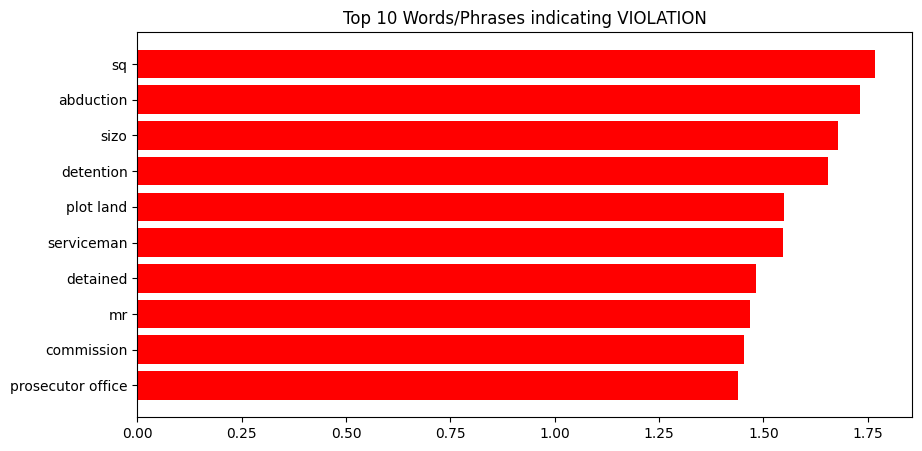

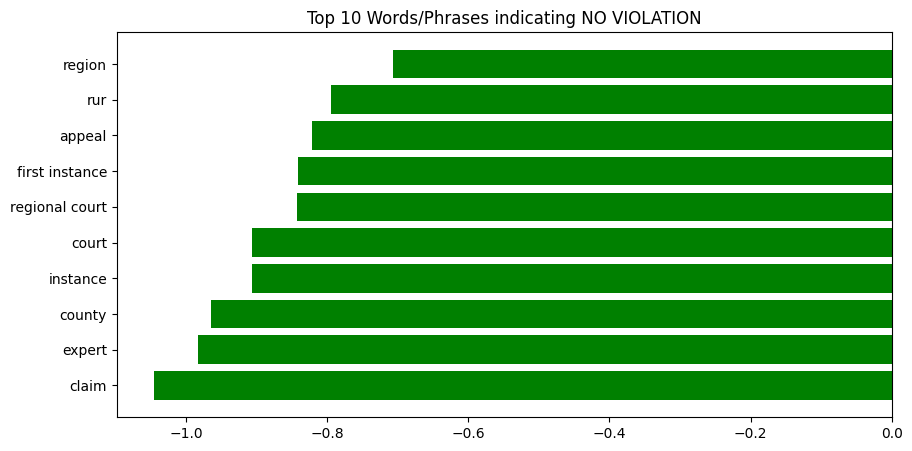

In [40]:
# Top 10 words for violation
top10_pos = top_pos_words[-10:]
top10_neg = top_neg_words[:10]

plt.figure(figsize=(10,5))
plt.barh(top10_pos, coefs[[np.where(feature_names==w)[0][0] for w in top10_pos]], color='red')
plt.title("Top 10 Words/Phrases indicating VIOLATION")
plt.show()

plt.figure(figsize=(10,5))
plt.barh(top10_neg, coefs[[np.where(feature_names==w)[0][0] for w in top10_neg]], color='green')
plt.title("Top 10 Words/Phrases indicating NO VIOLATION")
plt.show()


# Horizontal bar plots make it easy to see which words/phrases are most important

Red → words pushing toward violation

Green → words pushing toward no violation

# Why Bigram TF-IDF is Useful?

Single words  may be ambiguous (court, claim)

Pairs capture legal context (regional court, first instance)

Including both gives better model performance and better interpretability.

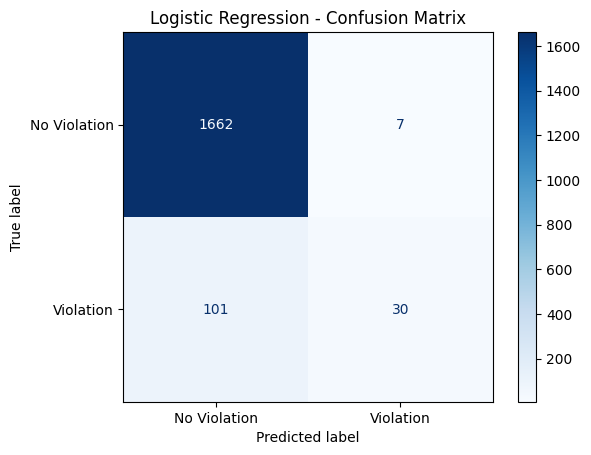

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Violation", "Violation"])
disp.plot(cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


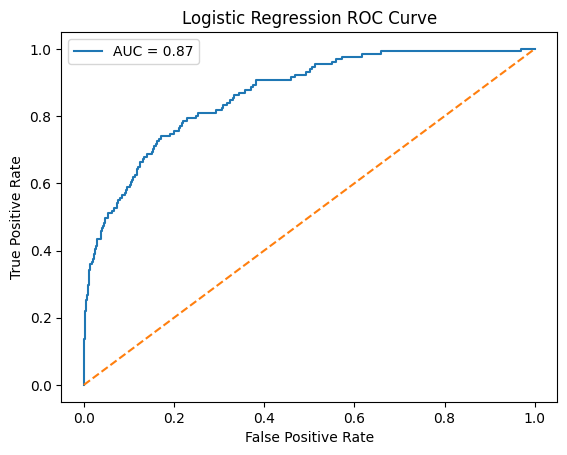

In [42]:
from sklearn.metrics import roc_curve, auc

y_prob = lr.predict_proba(X_test)[:,1]  # probability for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


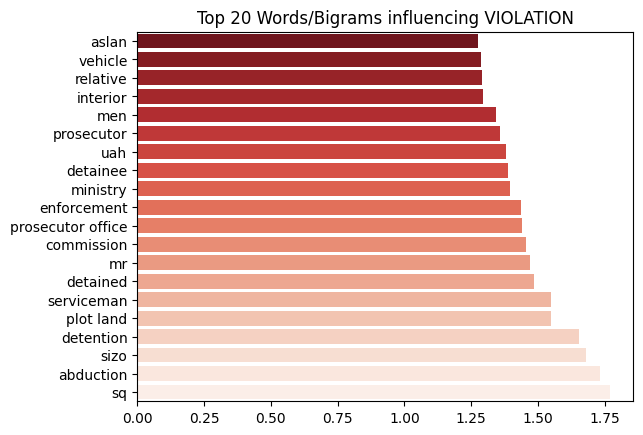

In [47]:
import seaborn as sns

top20_features = np.argsort(coefs)[-20:]
top_features_names = [feature_names[i] for i in top20_features]
top_features_values = coefs[top20_features]

sns.barplot(x=top_features_values, y=top_features_names, palette="Reds_r")
plt.title("Top 20 Words/Bigrams influencing VIOLATION")
plt.show()


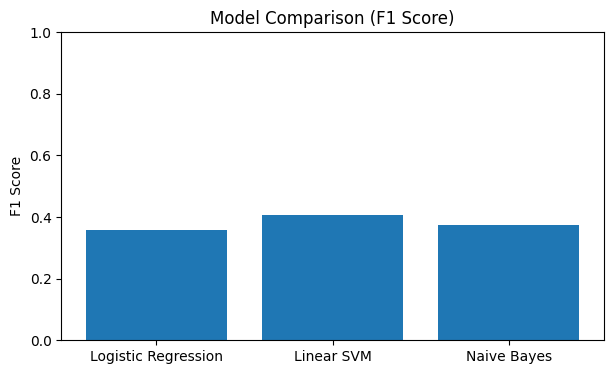

In [45]:
from sklearn.metrics import f1_score

models = ['Logistic Regression', 'Linear SVM', 'Naive Bayes']
f1_scores = [
    f1_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_svm),
    f1_score(y_test, y_pred_nb)
]

plt.figure(figsize=(7,4))
plt.bar(models, f1_scores)
plt.ylabel("F1 Score")
plt.title("Model Comparison (F1 Score)")
plt.ylim(0,1)
plt.show()


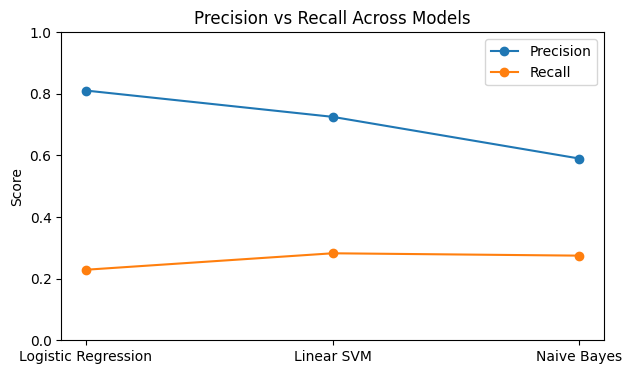

In [46]:
from sklearn.metrics import precision_score, recall_score

precision = [
    precision_score(y_test, y_pred_lr),
    precision_score(y_test, y_pred_svm),
    precision_score(y_test, y_pred_nb)
]

recall = [
    recall_score(y_test, y_pred_lr),
    recall_score(y_test, y_pred_svm),
    recall_score(y_test, y_pred_nb)
]

plt.figure(figsize=(7,4))
plt.plot(models, precision, label="Precision", marker='o')
plt.plot(models, recall, label="Recall", marker='o')
plt.legend()
plt.title("Precision vs Recall Across Models")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()


**We transformed legal judgments into numerical features using TF-IDF, capturing both individual terms and bi-grams. A Logistic Regression model was trained to predict whether a court found a violation. The model achieves competitive performance while remaining interpretable, making it suitable for legal analytics.**